## Model Loader
creating models and modeling scenario

In [9]:
import sys
import os
import numpy as np
import pandas as pd
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader

A scenario has a specific subset of data, features, and labels and trains and evaluates a specific model 
1. subset as informed by genre analysis 

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix#, accuracy_score, recall_score, 
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable("vegafusion")



DataTransformerRegistry.enable('vegafusion')

In [3]:
from configuration import  MODEL_INPUT_DATA_PATH
class ModelDataLoader():
    '''Loads and provides access to model input data and related information'''
    def __init__(self,version = '000'):
        self.df = pd.read_parquet(f'{MODEL_INPUT_DATA_PATH}model_input_{version}')
        self.feature_names = ['spectral_centroids_mean',
                'spectral_centroids_delta_mean',
                'spectral_centroids_accelerate_mean',
                'spectral_bandwidth_mean',
                'spectral_rolloff_mean',
                'zero_crossing_rate_mean',
                'rms_mean',
                'chroma_stft_mean',
                'mfccs_mean',
                'onset',
                'tempo',
                'contrast',
                'tonnetz',
                'mfccs_min',
                'mfccs_max']
        self.label_names = self.df.label.unique()


        self.add_named_feature_columns()
        
    def add_named_feature_columns(self):
        for index, feature in enumerate(self.feature_names):
            self.df[feature] = self.df.features.map(lambda features: features[index])




class ModelScenario():
    def __init__(self,model_data_loader = ModelDataLoader('003'), model = RandomForestClassifier(random_state=42),in_scope_labels = None, in_scope_features = None):
        self.model_data = model_data_loader
        if in_scope_labels == None:
            self.label_names = self.model_data.label_names
            self.df = self.model_data.df

        else:
            self.label_names = in_scope_labels
            self.df = self.model_data.df[self.model_data.df.label.isin(self.label_names)]

        
        if in_scope_features == None:
            self.feature_names = self.model_data.feature_names
        
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None 
        self.model = None
        self.y_pred = None
        self.model = model
        self.confusion_matrix = None
        self.confusion_matrix_normalized = None
        
        return
      
    
    def get_class_distribution(self):
        return pd.DataFrame(self.df['label'].value_counts(normalize=True) * 100).reset_index()
    
    def get_class_counts(self):
        return self.df.groupby('label')['label'].count().sort_values(ascending=False)

    
    def get_label_sample_df(self,df, label, sample_size):
        df_label = df[df.label == label]
        #return df_label.sample(sample_size).index
        if sample_size > len(df_label):
            return df_label
        return df_label.sample(sample_size)
    
    
    def get_model_data_sampled_by_label(self, sample_size):
        label_sample_indexes = []

        for index, label in enumerate(self.label_names):
            label_sample_df = self.get_label_sample_df(self.model_data.df, self.label_names[index], sample_size)
            #print("Generate ", len(label_sample_df), ' length sample')
            label_sample_indexes.append(label_sample_df)

        sampled_df = pd.concat(label_sample_indexes)
        return sampled_df
    
    def get_feature_distribution_by_label(self, feature_name):
        chart = alt.Chart(self.df).mark_boxplot(extent="min-max").encode(
            alt.X("label:N"),
            alt.Y(feature_name).scale(zero=False),
            alt.Color("label:N").legend(None),
            )
        return chart
    
    def initialize_data(self,df=None):
        if df is not None:
            self.df = df 
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.feature_names], self.df['label'], test_size=0.2, random_state=42,stratify=self.df['label'])
        return
    
    def initialize_model(self, model=None):
        if model is not None:
            self.model = model 
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)
        self.y_pred_prob = self.model.predict_proba(self.X_test)
        self.confusion_matrix = confusion_matrix(self.y_test, self.y_pred, labels=self.label_names)
        self.confusion_matrix_normalized = self.confusion_matrix.astype('float') / self.confusion_matrix.sum(axis=1)[:,np.newaxis]


    def get_classifcation_report(self):
        return classification_report(self.y_test, self.y_pred)
    
    def chart_confusion_matrix(self, normalized = True):
        cm = None
        fmt = None
        if normalized:
            cm = self.confusion_matrix_normalized
            fmt='.2f'
        else:
            cm=self.confusion_matrix
            fmt = 'd'
        
        sns.heatmap(cm, annot=True,fmt=fmt, cmap='YlGnBu', xticklabels=self.label_names, yticklabels=self.label_names)
        plt.ylabel('Prediction',fontsize=12)
        plt.xlabel('Actual',fontsize=12)
        plt.title('Confusion Matrix',fontsize=16)
        plt.show()

        return 

    

### Keras Exploration

In [4]:
from tensorflow import keras

2024-11-10 13:54:42.517598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import tensorflow as tf
from tqdm import tqdm 
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)


In [10]:
model_data_loader = ModelDataLoader('005')

In [93]:
features = model_data_loader.get_mfcc()
labels_series = model_data_loader.df['label']

In [70]:
feature_shapes = [feature.shape[1] for feature in features]
feature_shapes.sort()
#variety of length of the fccs
feature_shapes[0:5]

[1291, 1291, 1291, 1291, 1291]

In [ ]:
#reshape and normalize the length
reshaped_features = []
for feature in features:
    mfcc = [] 
    for vector in feature: 
        mfcc.append(vector[0:1200])
        mfcc_reshaped = np.array(mfcc)
    reshaped_features.append(mfcc_reshaped.reshape((1200,13,1)))
    


In [72]:
reshaped_features[0].shape

(1200, 13, 1)

In [116]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=reshaped_features[0].shape),
        keras.layers.Conv2D(13, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(26, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(8, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [117]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 1200, 13, 13)      130       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 600, 6, 13)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 600, 6, 26)        3068      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 300, 3, 26)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 23400)             0         
                                                                 
 dropout_3 (Dropout)         (None, 23400)            

In [ ]:
#Encode the labels 
unique_label_names = labels_series.unique()
label_to_int_map = {}
for index, label in enumerate(unique_label_names):
    label_to_int_map[label] = index  

numerical_labels = labels_series.map(label_to_int_map)

encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(labels_series.unique()))

#put to list and reshape again 
encoded_labels_array = [label.reshape((8,1)) for label in encoded_labels.numpy()]

In [149]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 50

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE)

#X_train, X_test, y_train, y_test = train_test_split(reshaped_features, encoded_labels_array, test_size=TEST_SIZE)

#for sample shape alignment 
#from keras.datasets import mnist
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [147]:
X_train.shape, y_train.shape

((697, 1200, 13, 1), (697, 8))

Epoch 1/50
8/8 [==============================] - 3s 398ms/step - loss: 2.0690 - accuracy: 0.1786 - val_loss: 2.0669 - val_accuracy: 0.2143
Epoch 2/50
8/8 [==============================] - 2s 274ms/step - loss: 2.0684 - accuracy: 0.1786 - val_loss: 2.0657 - val_accuracy: 0.2143
Epoch 3/50
8/8 [==============================] - 2s 303ms/step - loss: 2.0646 - accuracy: 0.1786 - val_loss: 2.0642 - val_accuracy: 0.2143
Epoch 4/50
8/8 [==============================] - 2s 290ms/step - loss: 2.0640 - accuracy: 0.1786 - val_loss: 2.0631 - val_accuracy: 0.2143
Epoch 5/50
8/8 [==============================] - 3s 335ms/step - loss: 2.0585 - accuracy: 0.1786 - val_loss: 2.0618 - val_accuracy: 0.2143
Epoch 6/50
8/8 [==============================] - 2s 292ms/step - loss: 2.0582 - accuracy: 0.1786 - val_loss: 2.0604 - val_accuracy: 0.2143
Epoch 7/50
8/8 [==============================] - 2s 277ms/step - loss: 2.0560 - accuracy: 0.1786 - val_loss: 2.0591 - val_accuracy: 0.2143
Epoch 8/50
8/8 [====

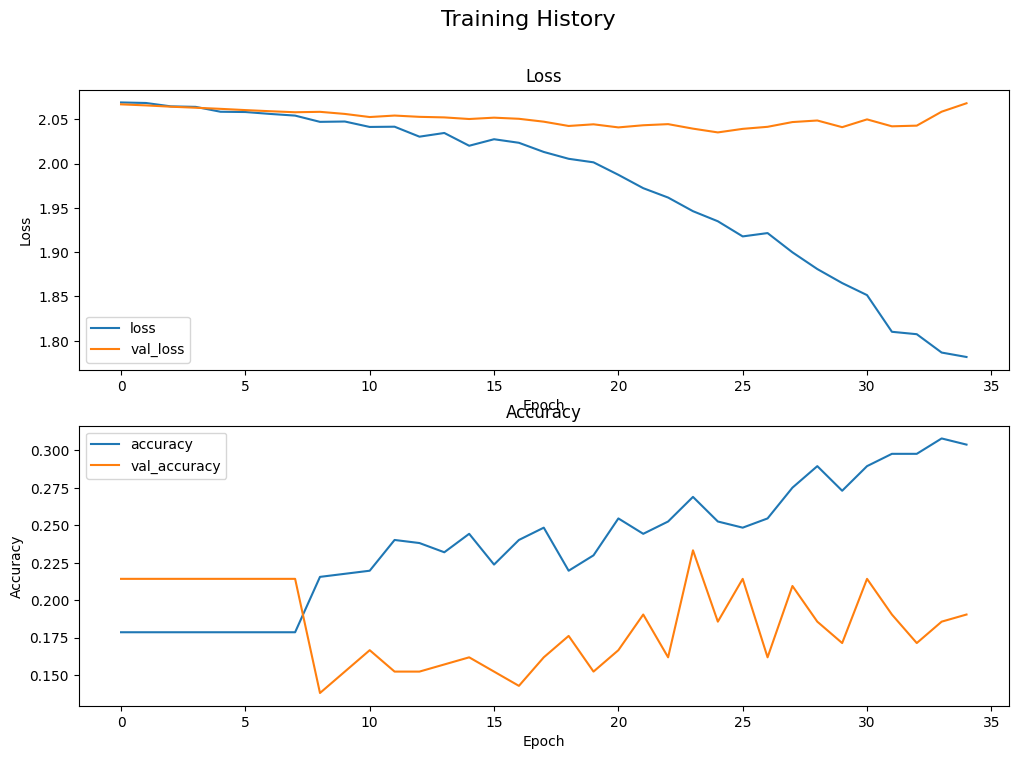

In [150]:
# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

### Scenario A: RandomForest Subset of Labels
for subset of labels ,all features

In [12]:
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
scenario_a = ModelScenario(in_scope_labels = in_scope_labels)
scenario_a.initialize_data()
scenario_a.initialize_model()

In [13]:
scenario_a.get_class_distribution()

,label,proportion
0,rock,48.531062
1,electronic,30.858225
2,hiphop,12.652503
3,classical,4.606647
4,jazz,2.320853
5,country,1.030711


In [14]:
print(scenario_a.get_classifcation_report())

              precision    recall  f1-score   support

   classical       0.77      0.82      0.79       263
     country       0.80      0.07      0.12        59
  electronic       0.70      0.71      0.71      1760
      hiphop       0.73      0.53      0.62       722
        jazz       0.71      0.08      0.14       132
        rock       0.80      0.89      0.84      2769

    accuracy                           0.76      5705
   macro avg       0.75      0.52      0.54      5705
weighted avg       0.76      0.76      0.75      5705



In [15]:
scenario_a.y_pred_prob

array([[0.  , 0.  , 0.82, 0.15, 0.  , 0.03],
       [0.22, 0.  , 0.2 , 0.03, 0.08, 0.47],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       ...,
       [0.  , 0.01, 0.08, 0.01, 0.01, 0.89],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.99],
       [0.  , 0.01, 0.05, 0.  , 0.  , 0.94]])

In [20]:
scenario_a.get_feature_distribution_by_label('tempo')

alt.Chart(...)

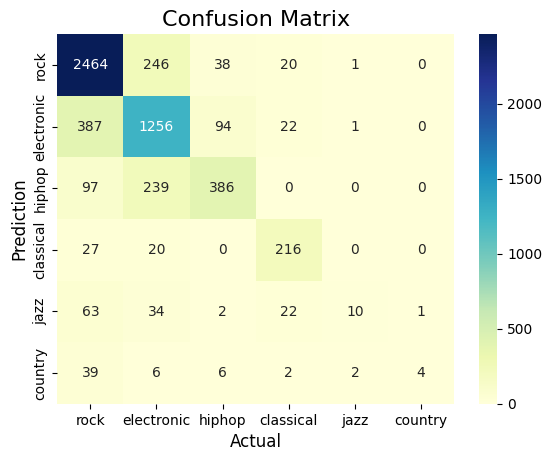

In [16]:
scenario_a.chart_confusion_matrix(normalized=False)

Notes on next steps: 
(Ways to interact with the data and forming genre blends:) 

Look at individual files, their probabality predictions, actual predictions, audio file player and feature value
Interface to chose a set of files to look at, where Actual genre is hip hop, yet prediction was Jazz (or any genre not hiphop)
where actual was country , predicted was rock 

Sumaries of one category by another , actual hiphop, summ

### Inpsecting prediction results 

In [7]:
#get rows of test dataset from full df 
df_test = scenario_a.df.iloc[list(scenario_a.y_test.index)]
df_test.head()

,index,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
132,27589,041961,fma,/project_data_source/free_music_archive/fma_sm...,rock,Rock,"[58, 98]","[58, 98]",1.0,44100,...,0.031559,0.173845,0.565953,3.703996,0.947365,129.199219,20.848719,0.010981,-511.517090,236.092041
542,6514,011794,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.169039,0.108710,0.567534,-0.671526,1.251471,95.703125,20.787889,-0.007900,-534.621338,146.543365
1289,20749,032693,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[542],[542],1.0,44100,...,0.061965,0.112183,0.469160,1.627861,1.250271,101.332718,20.703686,0.015194,-290.442993,233.686081
687,8535,014391,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.061779,0.321354,0.588482,7.622206,1.317294,126.048019,21.612099,0.012474,-449.994385,192.318939
1496,46639,068582,fma,/project_data_source/free_music_archive/fma_sm...,electronic,Electronic,[42],[42],1.0,44100,...,0.020820,0.289046,0.476293,3.311283,1.029140,120.185318,20.697523,-0.020339,-459.863495,242.045837


In [8]:
#get df of probability predictions
prob_df = pd.DataFrame(scenario_a.y_pred_prob, columns = scenario_a.label_names)

In [9]:
#Add to the data 
df_test.loc[:,prob_df.columns] = prob_df.to_numpy()

In [10]:
df_test

,index,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,...,contrast,tonnetz,mfccs_min,mfccs_max,rock,electronic,hiphop,classical,jazz,country
132,27589,041961,fma,/project_data_source/free_music_archive/fma_sm...,rock,Rock,"[58, 98]","[58, 98]",1.0,44100,...,20.848719,0.010981,-511.517090,236.092041,0.00,0.01,0.26,0.03,0.00,0.70
542,6514,011794,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,20.787889,-0.007900,-534.621338,146.543365,0.00,0.04,0.05,0.00,0.03,0.88
1289,20749,032693,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[542],[542],1.0,44100,...,20.703686,0.015194,-290.442993,233.686081,0.95,0.00,0.00,0.00,0.00,0.05
687,8535,014391,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,21.612099,0.012474,-449.994385,192.318939,0.11,0.00,0.46,0.01,0.14,0.28
1496,46639,068582,fma,/project_data_source/free_music_archive/fma_sm...,electronic,Electronic,[42],[42],1.0,44100,...,20.697523,-0.020339,-459.863495,242.045837,0.00,0.00,0.01,0.00,0.00,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,6508,011788,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,20.423096,-0.007530,-539.171875,201.800186,0.00,0.00,0.63,0.28,0.01,0.08
37,460,000694,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,20.292410,0.002417,-558.101440,187.510513,0.00,0.01,0.65,0.25,0.00,0.09
463,5759,010698,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,21.406958,0.001907,-530.814819,223.712860,0.17,0.00,0.36,0.03,0.11,0.33
1063,16159,026034,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,22.093687,0.003755,-467.264954,219.155930,0.01,0.02,0.29,0.14,0.13,0.41


### Scenario B: Variation with drawing class balanced sample
start with equal size sample by label 

In [266]:
scenario_b = ModelScenario(in_scope_labels = in_scope_labels)

scenario_b.initialize_data(scenario_b.get_model_data_sampled_by_label(400))
scenario_b.initialize_model()
print(scenario_b.get_class_distribution(),scenario_b.get_class_counts(),scenario_b.get_classifcation_report())

        label  proportion
0        rock   14.942099
1  electronic   14.942099
2      hiphop   14.942099
3   classical   14.942099
4        jazz   14.942099
5         pop   14.942099
6     country   10.347404 label
classical     400
electronic    400
hiphop        400
pop           400
jazz          400
rock          400
country       277
Name: label, dtype: int64               precision    recall  f1-score   support

   classical       0.74      0.84      0.79        80
     country       0.69      0.48      0.57        56
  electronic       0.49      0.44      0.46        80
      hiphop       0.58      0.65      0.61        80
        jazz       0.47      0.53      0.49        80
         pop       0.43      0.40      0.41        80
        rock       0.57      0.57      0.57        80

    accuracy                           0.56       536
   macro avg       0.57      0.56      0.56       536
weighted avg       0.56      0.56      0.56       536



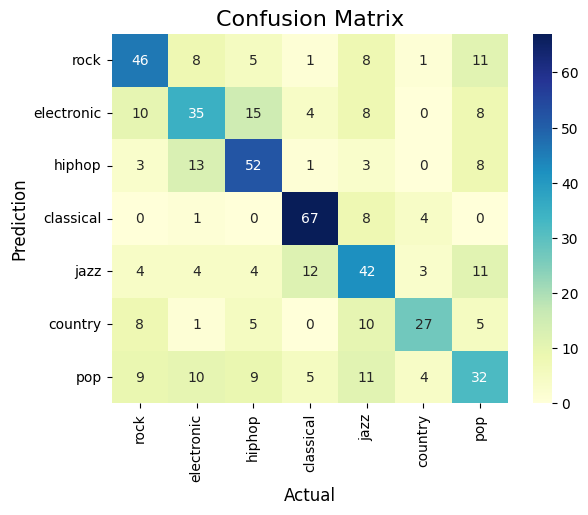

In [267]:
scenario_b.chart_confusion_matrix(normalized=False)

In [268]:
scenario_b.y_pred_prob[0]

array([0.03, 0.1 , 0.01, 0.02, 0.09, 0.22, 0.53])

In [269]:
scenario_b.get_feature_distribution_by_label('tempo')

alt.Chart(...)